<a href="https://colab.research.google.com/github/DmitryKutsev/NIS_SentiFrame/blob/master/NIS_21_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2[fast]
!wget https://raw.githubusercontent.com/nicolay-r/RuSentiFrames/master/collection.json

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 7.1MB 8.0MB/s 
     |████████████████████████████████| 378kB 50.5MB/s 
  Created wheel for DAWG: filename=DAWG-0.8.0-cp36-cp36m-linux_x86_64.whl size=859439 sha256=7fc593fade072b2baa7dd281eab440da36940bd148868b8afa604340ba07168f
  Stored in directory: /root/.cache/pip/wheels/3d/1f/f0/a5b1f9d02e193c997d252c33d215f24dfd7a448bc0166b2a12
Successfully built DAWG
--2020-04-20 20:36:43--  https://raw.githubusercontent.com/nicolay-r/RuSentiFrames/master/collection.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 606414 (592K) [text/plain]
Saving to: ‘collection.json’

collection.json     100%[===================>] 592.20K  --.-KB/s    in 0.06s   

2020-04-20 20:36:44 (9.44 M

In [0]:
#!rm collection.json.1
#!ls
import gensim
from collections import Counter
import json
import pandas as pd
import numpy as np
from os import listdir
from sklearn.metrics.pairwise import cosine_distances
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [0]:
%%capture
# at least two mutual negative attitudes
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/neg_a0_a1_mutual.json
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/neg_a0_a2_mutual.json
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/neg_a1_a2_mutual.json

# at least two mutual positive attitudes
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/pos_a0_a1_mutual.json
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/pos_a0_a2_mutual.json
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/pos_a1_a2_mutual.json

# at least two opposite attitudes (only a0/a1 show opposite attitudes toward each other)
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/opp_a0_a1_candidates_l.json

In [0]:
!wget rusvectores.org/static/models/rusvectores2/news_mystem_skipgram_1000_20_2015.bin.gz

In [5]:
skipgram_model = gensim.models.KeyedVectors.load_word2vec_format('news_mystem_skipgram_1000_20_2015.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def make_seed_embedding(seed_dict, model):
  '''
  Принимает на вход список, на выходе дает средний вектор всех слов из этого списка
  '''
  summ = 0
  if model == skipgram_model:
    for verb in seed_dict:
      summ = summ + model[verb + '_V']
    vector = summ/len(seed_dict)

  else:
    for verb in seed_dict:
      summ = summ + model.get_vector(verb)
    vector = summ/len(seed_dict)

  return vector

In [0]:
def verb_distance_df_w2v(verb_list, model,
                  seed1=['ценить'],
                  seed2=['убивать']):

  df = pd.DataFrame({'variant':verb_list})

  distance_to_seed1 = df['variant'].apply(
      lambda x: cosine_distances(
          np.atleast_2d(make_seed_embedding([x], model)), 
          np.atleast_2d(make_seed_embedding(seed1, model))).item() 
          if (x+'_V' in model.vocab) or (x in model.vocab) else None)
  distance_to_seed2 = df['variant'].apply(
      lambda x: cosine_distances(
          np.atleast_2d(make_seed_embedding([x], model)), 
          np.atleast_2d(make_seed_embedding(seed2, model))).item() 
          if (x+'_V' in model.vocab) or (x in model.vocab) else None)

  df['distance_to_seed1'] = distance_to_seed1
  df['distance_to_seed2'] = distance_to_seed2

  df['attributed_polarity'] = np.where(
      # если дистанция до первого сида меньше
      df['distance_to_seed1'] < df['distance_to_seed2'], 
      # то в результирующую колонку кладём 'seed1', иначе 'seed2'
      'seed1', 'seed2')
  
  df['seed1'] = ' '.join(seed1)
  df['seed2'] = ' '.join(seed2)

  return df

In [0]:
def highlight_true(s):
    '''
    green
    '''
    is_true = s == True
    return ['background-color: green' if v else '' for v in is_true]

def highlight_none(s):
    '''
    grey
    '''
    is_none = s == None
    return ['background-color: grey' if v else '' for v in is_none]

**Skipgram**

In [0]:
  list2check = ['порицать', 'осуждать', 'негодовать',
            'обвинять', 'наказывать', 
            'ненавидеть', 'убивать', 'разрушать', 'одобрять', 'хвалить', 'поощрять', 
            'обожать', 'восхищаться', 'восторгаться', 
            'нравиться', 'ценить', 'гордиться',
            'хвалить', 'нахваливать', 'превозносить', 'фанфарониться']
df = verb_distance_df_w2v(list2check, skipgram_model)
# df

In [0]:
# styled = df.style.apply(highlight_true)
# styled

In [0]:
def seed_percentage(pd_df, seed=1):
  if seed:
    n_preds = len(pd_df[
      #  эти две строчки обязательны
      (pd_df['distance_to_seed1'].notnull())
      & (pd_df['distance_to_seed2'].notnull())
      & (pd_df['attributed_polarity']=='seed{}'.format(seed))
      ])
    return round(n_preds/len(pd_df), 2)
  else:
    nans = pd_df[
      #  эти две строчки обязательны
      (pd_df['distance_to_seed1'].isnull())
      & (pd_df['distance_to_seed2'].isnull())
      ]
    
    return round(len(nans)/len(pd_df), 2)
    # return pd_df

In [144]:
print ('file_name', '\t\t', 'pos_labels, %', '\t', 'neg_labels, %', '\t', 'no_label, %', '\t', 'list_length')

for fname in listdir():
  if (fname.endswith('.json') and (not 'meta' in fname)):
    with open (fname, 'r', encoding='utf-8') as f:
      list2check = json.load(f, encoding="utf-8")
    df2check = verb_distance_df_w2v(list2check, skipgram_model)
    perc_pos = seed_percentage(pd_df=df2check, seed=1)
    perc_neg = seed_percentage(pd_df=df2check, seed=2)
    perc_nan = seed_percentage(pd_df=df2check, seed=0)
    print (fname, '\t', perc_pos, '\t\t', perc_neg, '\t\t', perc_nan, '\t\t', len(df2check))

file_name 		 pos_labels, % 	 neg_labels, % 	 no_label, % 	 list_length
neg_a0_a2_mutual.json 	 0.04 		 0.53 		 0.43 		 89
pos_a1_a2_mutual.json 	 0.39 		 0.18 		 0.43 		 28
opp_a0_a1_candidates_l.json 	 0.29 		 0.24 		 0.47 		 17
pos_a0_a2_mutual.json 	 0.38 		 0.38 		 0.25 		 16
pos_a0_a1_mutual.json 	 0.33 		 0.26 		 0.41 		 427
neg_a1_a2_mutual.json 	 0.03 		 0.41 		 0.55 		 58
neg_a0_a1_mutual.json 	 0.12 		 0.46 		 0.43 		 1022


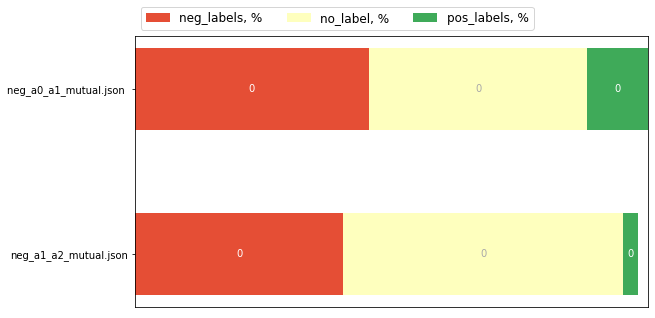

In [142]:
import numpy as np
import matplotlib.pyplot as plt


category_names = ['neg_labels, %', 'no_label, %', 'pos_labels, %']
results = {
    'neg_a0_a1_mutual.json ': [float(x) for x in '0.46 		 0.43 0.12'.split()],
    'neg_a1_a2_mutual.json': [float(x) for x in '0.41 		 0.55 0.03'.split()],
    # 'Question 3': [35, 37, 7, 2, 19],
    # 'Question 4': [32, 11, 9, 15, 33],
    # 'Question 5': [21, 29, 5, 5, 40],
    # 'Question 6': [8, 19, 5, 30, 38]
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='large')

    return fig, ax


survey(results, category_names)
plt.show()